In [26]:
import json
import os
from pathlib import Path

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
import shapely
from dotenv import load_dotenv
from shapely.plotting import plot_polygon

load_dotenv()

True

In [44]:
figure_path = Path(
    "/Users/rodolfofigueroa/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/cupum_data/pres/fig",
)

In [3]:
ZONE_NAMES_MAP = {
    "01.1.01": "aguascalientes",
    "02.1.01": "tijuana",
    "02.2.02": "ensenada",
    "02.2.03": "mexicali",
    "03.2.01": "la paz",
    "03.2.02": "los cabos",
    "04.2.01": "campeche",
    "05.1.01": "la laguna",
    "05.1.02": "monclova-frontera",
    "05.1.03": "piedras negras",
    "05.1.04": "saltillo",
    "06.1.01": "colima-villa de álvarez",
    "07.1.01": "tapachula",
    "07.1.02": "tuxtla\ngutiérrez",
    "08.1.01": "chihuahua",
    "08.1.02": "delicias",
    "08.2.03": "juárez",
    "09.1.01": "mexico city",
    "10.2.01": "durango",
    "11.1.01": "celaya",
    "11.1.02": "león",
    "11.2.03": "guanajuato",
    "11.2.04": "irapuato",
    "12.1.01": "chilpancingo",
    "12.2.02": "acapulco",
    "13.1.01": "pachuca",
    "13.1.02": "tulancingo",
    "14.1.01": "guadalajara",
    "14.1.02": "puerto vallarta",
    "15.1.01": "toluca",
    "16.1.01": "la piedad-pénjamo",
    "16.1.02": "morelia",
    "16.1.03": "zamora",
    "16.2.04": "uruapan",
    "17.1.01": "cuautla",
    "17.1.02": "cuernavaca",
    "18.1.01": "tepic",
    "19.1.01": "monterrey",
    "20.1.01": "oaxaca",
    "21.1.01": "puebla-tlaxcala",
    "21.1.02": "san martín texmelucan",
    "21.1.03": "tehuacán",
    "22.1.01": "querétaro",
    "23.1.01": "cancún",
    "23.2.02": "chetumal",
    "24.1.01": "san luis potosí",
    "25.2.01": "culiacán",
    "25.2.02": "los mochis",
    "25.2.03": "mazatlán",
    "26.1.01": "guaymas",
    "26.2.02": "ciudad obregón",
    "26.2.03": "hermosillo",
    "26.2.04": "nogales",
    "27.1.01": "villahermosa",
    "28.1.01": "reynosa",
    "28.1.02": "tampico",
    "28.2.03": "ciudad victoria",
    "28.2.04": "matamoros",
    "28.2.05": "nuevo laredo",
    "29.1.01": "tlaxcala-apizaco",
    "30.1.01": "coatzacoalcos",
    "30.1.02": "córdoba",
    "30.1.03": "minatitlán",
    "30.1.04": "orizaba",
    "30.1.05": "poza rica",
    "30.1.06": "veracruz",
    "30.1.07": "xalapa",
    "31.1.01": "mérida",
    "32.1.01": "zacatecas-guadalupe",
}
zones_name_map_sorted = {
    k: v for k, v in sorted(ZONE_NAMES_MAP.items(), key=lambda item: item[1])
}

In [4]:
out_path = Path(os.environ["OUT_PATH"])

In [5]:
with open("./zones.json") as f:
    zones = json.load(f)

In [7]:
drop_1990 = {"02.2.02": ["0200101246152", "020010124724A", "0200101247254"]}

In [8]:
year = 1990


def calculate_average_df(year: int) -> gpd.GeoDataFrame:
    df_average = []
    for zone in zones:
        df_shaped = (
            gpd.read_file(
                out_path / "zone_agebs" / "shaped" / str(year) / f"{zone}.gpkg",
            )
            .set_index("CVEGEO")
            .sort_index()
        )
        df_translated = (
            gpd.read_file(
                out_path / "zone_agebs" / "translated" / str(year) / f"{zone}.gpkg",
            )
            .set_index("CVEGEO")
            .sort_index()
        )

        if zone in drop_1990 and year == 1990:
            df_shaped = df_shaped.loc[~df_shaped.index.isin(drop_1990[zone])]
            df_translated = df_translated.loc[
                ~df_translated.index.isin(drop_1990[zone])
            ]

        centroid_start = df_shaped.centroid
        centroid_end = df_translated.centroid

        distances = centroid_start.distance(centroid_end, align=True).rename("distance")
        dx = (centroid_end.x - centroid_start.x).rename("dx")
        dy = (centroid_end.y - centroid_start.y).rename("dy")
        df_distance = gpd.GeoDataFrame(
            pd.concat(
                [
                    distances,
                    df_shaped["POBTOT"],
                    dx,
                    dy,
                    df_shaped["geometry"].centroid.rename("geometry"),
                ],
                axis=1,
                ignore_index=False,
            ),
        ).assign(
            angle=lambda df: np.degrees(np.arctan2(df["dy"], df["dx"])),
            magnitude=lambda df: np.sqrt(df["dx"] ** 2 + df["dy"] ** 2),
        )

        df_average.append(
            {
                "zone": zone,
                "average_displacement": df_distance["distance"].mean(),
                "weighted_average_displacement": (
                    df_distance["distance"] * df_distance["POBTOT"]
                ).sum()
                / df_distance["POBTOT"].sum(),
                "population": df_distance["POBTOT"].sum(),
                "num_agebs": len(df_distance),
                "average_ageb_area": df_shaped["geometry"].area.mean(),
                "total_ageb_area": df_shaped["geometry"].area.sum(),
                "average_dx": dx.mean(),
                "average_dy": dy.mean(),
                "weighted_average_dx": (dx * df_distance["POBTOT"]).sum()
                / df_distance["POBTOT"].sum(),
                "weighted_average_dy": (dy * df_distance["POBTOT"]).sum()
                / df_distance["POBTOT"].sum(),
                "geometry": df_shaped.centroid.union_all().centroid,
            },
        )

    return gpd.GeoDataFrame(
        pd.DataFrame(df_average).set_index("zone"),
        geometry="geometry",
        crs=df_shaped.crs,
    ).assign(
        center_dist=lambda df: df.distance(df.loc["09.1.01", "geometry"]),
        state_code=lambda df: df.index.str[:2].astype(int),
    )

In [9]:
df_average_1990 = calculate_average_df(1990)
df_average_2000 = calculate_average_df(2000)

In [57]:
def plot_dumbbell(df_average: pd.DataFrame, *, ax: plt.Axes) -> None:
    df_average = df_average.loc[list(zones_name_map_sorted.keys())]
    for zone, row in df_average.iterrows():
        ax.plot(
            [zone, zone],
            [row[1990], row[2000]],
            c="#A9A9A9",
            linestyle="-",
            zorder=1,
            lw=3,
        )

    ax.scatter(df_average.index, df_average[1990], c="C0", s=50, label=1990, zorder=2)
    ax.scatter(df_average.index, df_average[2000], c="C1", s=50, label=2000, zorder=2)


def add_annotations(
    offsets: dict[str, tuple[float, float]],
    df_average: pd.DataFrame,
    *,
    ax: plt.Axes,
) -> None:
    for idx in offsets:
        ymax = ax.get_ylim()[1]
        ymean = np.clip(
            (df_average.loc[idx, 1990] + df_average.loc[idx, 2000].item()) / 2,
            0,
            ymax,
        )

        ax.annotate(
            zones_name_map_sorted[idx].title(),
            xy=(idx, ymean),
            xytext=(offsets[idx][0], ymean + offsets[idx][1]),
            arrowprops={
                "width": 2,
                "lw": 0,
                "headlength": 1,
                "headwidth": 1,
                "color": "#F08080",
                "shrink": 0.05,
            },
            ha="left",
            va="bottom",
            fontsize=16,
            annotation_clip=False,
        )

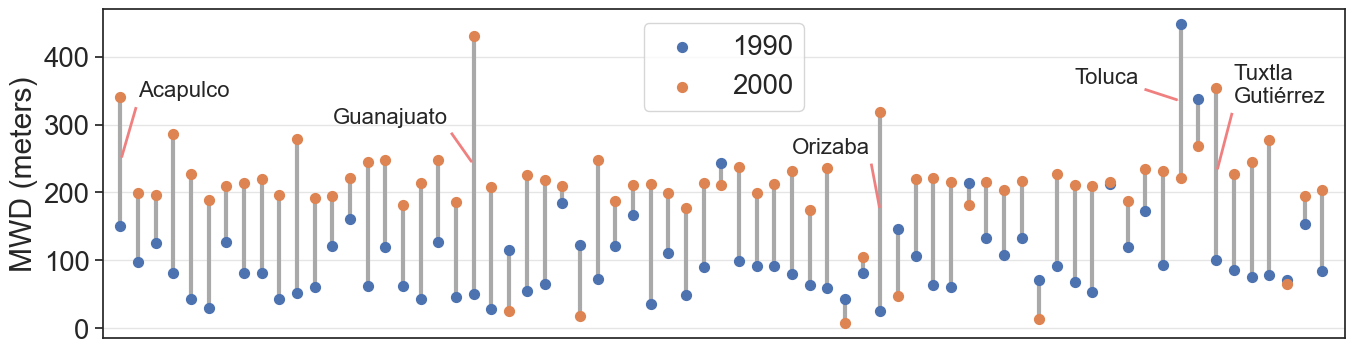

In [58]:
sns.set_theme(style="ticks", font_scale=1.8)

df_average = pd.concat(
    [
        df_average_1990["weighted_average_displacement"].rename(1990),
        df_average_2000["weighted_average_displacement"].rename(2000),
    ],
    axis=1,
)

fig, ax = plt.subplots(figsize=(14, 4))
plot_dumbbell(df_average, ax=ax)
# ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, fontsize=10)
ax.set_xticks([])
ax.set_ylabel("MWD (meters)")

offsets = {
    "07.1.02": (63, 100),
    "11.2.03": (12, 55),
    "12.2.02": (1, 90),
    "15.1.01": (54, 20),
    "30.1.04": (38, 80),
}
add_annotations(offsets, df_average, ax=ax)

ax.legend(loc="upper center")

ax.set_axisbelow(True)
ax.grid(alpha=0.5)
ax.set_xlim(-1, 69.3)

fig.tight_layout()
fig.savefig(
    figure_path / "weighted_displacement_dumbbell.pdf",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

In [12]:
def calculate_delta_df(df_average: gpd.GeoDataFrame, use_weighted: bool = True):
    if use_weighted:
        prefix = "weighted_"
    else:
        prefix = ""
    return (
        df_average.filter([f"{prefix}average_dx", f"{prefix}average_dy", "geometry"])
        .rename(columns={f"{prefix}average_dx": "dx", f"{prefix}average_dy": "dy"})
        .assign(
            delta=lambda df: np.sqrt(df["dx"] ** 2 + df["dy"] ** 2),
            angle=lambda df: np.degrees(np.arctan2(df["dy"], df["dx"])),
            delta_norm=lambda df: df["delta"] / df["delta"].max(),
        )
    )


def plot_delta(df_delta: gpd.GeoDataFrame, *, ax: plt.Axes, scale: float):
    df_delta.plot(ax=ax, color="C0", markersize=25, autolim=False)

    for idx, row in df_delta.iterrows():
        x, y = row.geometry.x, row.geometry.y
        angle_rad = np.radians(row.angle)
        length = row["delta"] * scale
        dx = length * np.cos(angle_rad)
        dy = length * np.sin(angle_rad)
        ax.arrow(
            x,
            y,
            dx,
            dy,
            head_width=0 * length,
            head_length=0.1 * length,
            fc="#F08080",
            ec="#F08080",
            lw=1.5,
        )

In [13]:
df_delta_1990 = calculate_delta_df(df_average_1990, use_weighted=True)
df_delta_2000 = calculate_delta_df(df_average_2000, use_weighted=True)

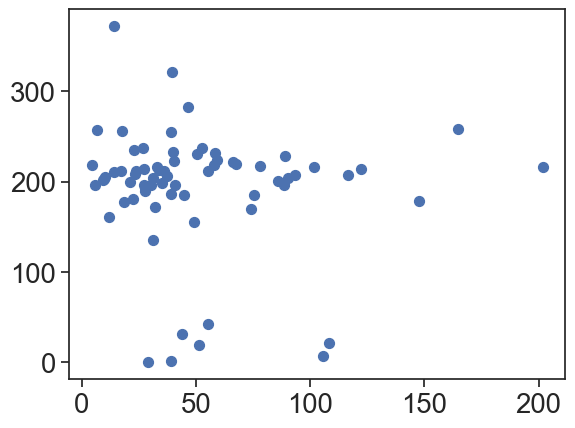

In [50]:
idx = df_delta_1990.sort_index().index

plt.scatter(
    df_delta_1990.loc[idx, "delta"],
    df_delta_2000.loc[idx, "delta"],
    c="C0",
    s=50,
    label=1990,
    zorder=2,
)

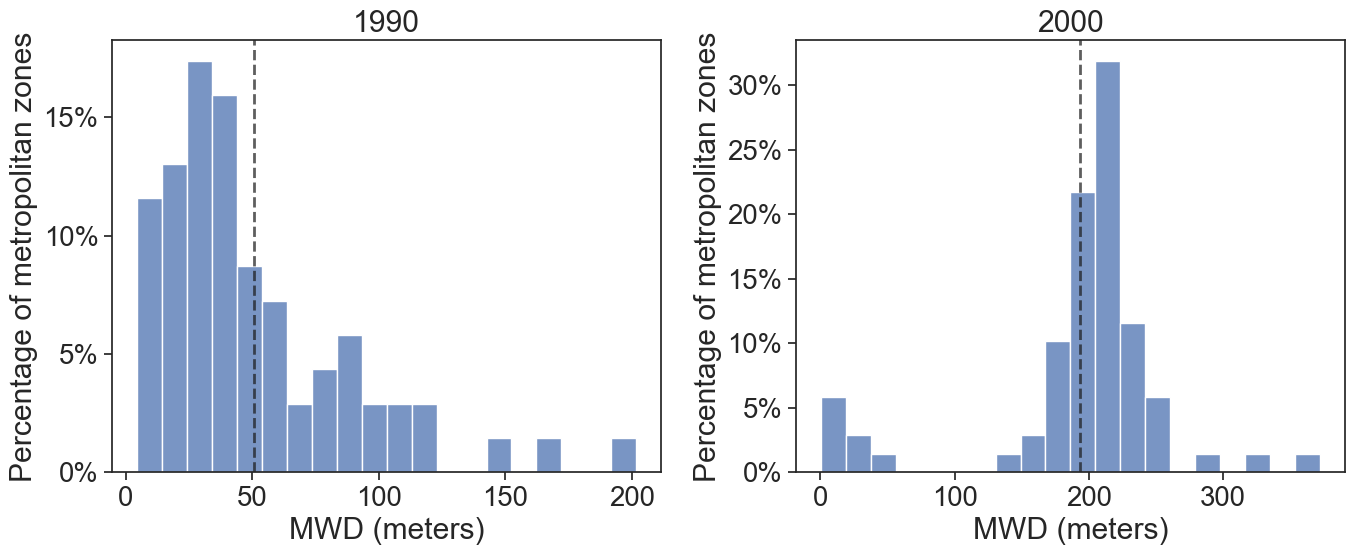

In [49]:
sns.set_theme(style="ticks", font_scale=1.8)

fig, (axl, axr) = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df_delta_1990["delta"], bins=20, ax=axl, color="C0", stat="percent")
sns.histplot(df_delta_2000["delta"], bins=20, ax=axr, color="C0", stat="percent")

axl.axvline(
    df_delta_1990["delta"].mean(),
    0,
    100,
    color="k",
    alpha=0.7,
    linestyle="--",
    lw=2,
)
axr.axvline(
    df_delta_2000["delta"].mean(),
    0,
    100,
    color="k",
    alpha=0.7,
    linestyle="--",
    lw=2,
)

axl.set_title("1990")
axr.set_title("2000")

for ax in [axl, axr]:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(100, decimals=0))
    ax.set_xlabel("MWD (meters)")
    ax.set_ylabel("Percentage of metropolitan zones")

fig.tight_layout()
fig.savefig(
    figure_path / "weighted_displacement_histograms.pdf",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

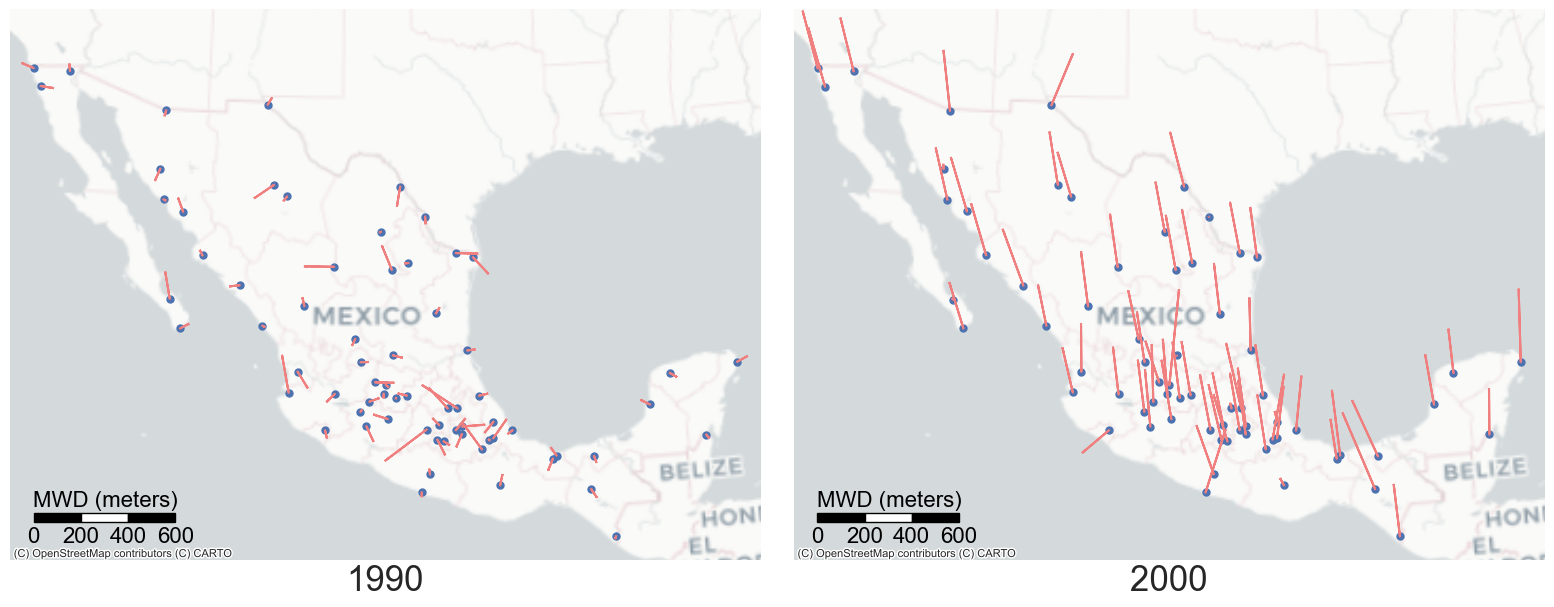

In [60]:
scale = 1000

xmin = min(df_delta_1990.total_bounds[0], df_delta_2000.total_bounds[0]) - 100000
xmax = max(df_delta_1990.total_bounds[2], df_delta_2000.total_bounds[2]) + 100000
ymin = min(df_delta_1990.total_bounds[1], df_delta_2000.total_bounds[1]) - 100000
ymax = max(df_delta_1990.total_bounds[3], df_delta_2000.total_bounds[3]) + 250000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
plot_delta(df_delta_1990, ax=ax1, scale=scale)
plot_delta(df_delta_2000, ax=ax2, scale=scale)

for ax in (ax1, ax2):
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis("off")
    cx.add_basemap(
        ax,
        crs=df_delta_2000.crs,
        source=cx.providers.CartoDB.Positron,
        zoom=4,
    )

startx = xmin + 100000
starty = ymin + 180000
rectangle_height = 20000
rectangle_width = 200

rectangle_offset = 0

for ax in (ax1, ax2):
    for i in range(3):
        scale_rectangle = shapely.box(
            startx + i * rectangle_width * scale,
            starty - rectangle_height,
            startx + (i * rectangle_width + 200) * scale,
            starty + rectangle_height,
        )
        if i % 2 == 0:
            color = "black"
        else:
            color = "white"
        plot_polygon(
            scale_rectangle,
            ax=ax,
            add_points=False,
            alpha=1,
            color=color,
            edgecolor="black",
            lw=1,
        )

        coords = [(x, y - 15_000) for x, y in scale_rectangle.exterior.coords]
        ax.annotate(
            f"{i * 200}",
            xy=coords[3],
            fontsize=16,
            ha="center",
            va="top",
            color="black",
        )

    annot_x = coords[0][0]
    annot_y = coords[0][1]
    ax.annotate(
        f"{(i + 1) * 200}",
        xy=(annot_x, annot_y),
        fontsize=16,
        ha="center",
        va="top",
        color="black",
    )

    ax.annotate(
        "MWD (meters)",
        xy=(annot_x - 295000, annot_y + 150000),
        fontsize=16,
        ha="center",
        va="top",
        color="black",
    )

    ax.set_aspect("equal")

ax1.set_title("1990", fontsize=25, y=-0.07)
ax2.set_title("2000", fontsize=25, y=-0.07)

fig.tight_layout()
fig.savefig(
    figure_path / "weighted_displacement_arrows.pdf",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

In [229]:
ref_point

(1354033.2240720717, 389737.3656560173)